# Copyright

<PRE>
Jelen iPython notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült. 
A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning
Jelen notebook Nicolas P. Rougier munkája alapján készült, melyet BSD licensz véd: http://www.labri.fr/perso/nrougier/downloads/mlp.py

A notebook bármely részének újra felhasználása, publikálása csak a szerzők írásos beleegyezése esetén megegengedett.

2017 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu), Császár Márk
</PRE>

# XOR feladat neuron hálós megközelítése

Először a historikisan is nagy jelentőségű XOR problémát (aminek közvetve köszönhetjük a backpropagation algoritmust) fogjuk megoldani "pure" Python-ban. 

A XOR probléma a gépi tanulás szempontjából azért érdekes, mert míg az AND és az OR logikai függvények architektúrális szempontból megoldhatóak egyetlen neuron segítségével, addig a XOR-ra ez nem teljesül. Az AND és az OR esetében létezik a függvény által felveheto kimeneti értékek között egy olyan hipersík (szeparálósík), amely segítségével egyértelmű a szeparáció.

A XOR probléma további tárgyalásához tekintsük az alábbi igazságtáblát:


  A     | B   | A XOR B
  :----:| :----:|:--------:
  0     | 0   |    0
  1     | 0   |    1
  0     | 1   |    1
  1     | 1   |    0

Populating the interactive namespace from numpy and matplotlib


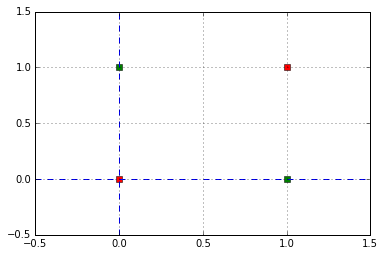

In [44]:
# Pylab grafikus megjelenítocsomag meghívása (a % jel a notebook miatt szükséges)
%pylab inline

# "Igaz" logikai értékek megadása
true_x = [1, 0]
true_y = [0, 1]

# "Hamis" logikai értékek megadása
false_x = [0, 1]
false_y = [0, 1]

# Jelöljük pirossal a hamis logikai értékeket, zölddel pedig az igazakat.
plot1 = plt.plot(true_x, true_y,'gs')
plot2 = plt.plot(false_x, false_y, 'rs')

# A jobb ábrázálhatóság miatt, szélesebb tartományokat jelenítünk meg
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
# Négyzetrács megjelenítése
plt.grid(True)
# Az x és y tengely megjelenítése
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
# Az ábra kirajzolása
plt.show()

Mint ahogy a fenti ábrán is látszódik, nem tudjuk egyetlen szeparáló síkkal (2 dimenzióban egyenessel) külön választani az igaz és a hamis értékeket.

Mivel egyetlen síkkal nem tudjuk szétválasztani a kimeneteket ezért a neurális hálózat be- és kimeneti rétege közé szükségszerű, hogy további, un. rejtett réteg(ek)et illesszünk be. 

Mielőtt a konkrét programkóddal ismerkednénk meg, tekintsük át egy mesterséges neurális hálózat általános architektúráját, felépítését. Ahhoz, hogy neurális hálózatunk felügyelt tanítás során rendeltetésszerűen működjön, szükségünk van:

 - Tanító adatokra (bemenet és felügyelt esetben kimenet),
 - Magára a neurális hálózatra, amely magában foglal:
   - bemeneti réteget, egy kimeneti réteget, illetve köztük elhelyezkedo rejtett réteg(ek)et,
   - rétegenként tetszőleges számú neuronokat, 
   - a rétegeket összekötő, különböző súlyokkal rendelkező éleket,
   - a neuronokon elvégzett lineáris (súlyozott összegzés), illetve nem lineáris függvényeket (pl. sigmoid, tanh, ReLU, stb.).
 - Tanítási fázist:
   - a bemenő adatokat "végigküldjük" a hálózaton (forward propagation),
   - a bemenő adatok alapján kiszámoljuk a hálózat által "jósolt" eredményt,
   - a jósolt eredmény és a tanító adatokban szereplő elvárt eredmény közötti kapcsolat kiszámítása (költségfüggvény),
   - a kapott hibaérték visszaterjesztése (backpropagation) a hálózaton, a láncszabály és a parciális deriválás módszerével (gradiensek kiszámítása)
   - a rétegek közötti súlyok frissítését a gradiensek segítségével.
   
Első lépésként importáljuk a már jól ismert Numpy csomagot, amire np-ként fogunk hivatkozni, illetve a további szükséges csomagokat:

In [45]:
import numpy as np
from sklearn import preprocessing
import copy

Töltsük be a matplotlib grafikus megjelenítőt:

In [46]:
%matplotlib inline

Az aktivációs függvény definiálása. A "forward" lépésben a hálózatot alkotó neuronokkal két műveletet hajtunk végre: (1) Egy súlyozott lineáris összegzést, (2) illetve egy nemlineáris aktiválási függvényt. A lineáris függvény nem csinál mást, minthogy összegzi az adott neuronhoz beérkező értékeket a hozzá vezető súly értékével megszorozva. Ezután a kapott eredményen alkalmazzuk a nemlineáris aktivációs függvényt. Ez általában annyit csinál, hogy amennyiben az argomentuma (a korábbi szummázás)meghalad egy bizonyos küszöbértéket, akkor a neuron továbbítja a következő rétegre az adatokat. Itt a sigmoid-ot használjuk erre a célra, amit előbb definiálunk majd megnézzük, hogy hogyan néz ki:

In [47]:
def activation(x):
    return 1 / (1 + np.exp(-x))

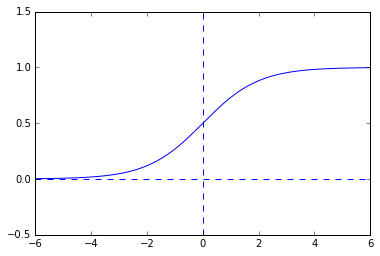

In [48]:
segedX=np.linspace(-6,6,200)
# A jobb ábrázálhatóság miatt, szélesebb tartományokat jelenítünk meg
plt.xlim(-6, 6)
plt.ylim(-0.5, 1.5)
# Az x és y tengely megjelenítése
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.plot(segedX,activation(segedX))

Következőnek definiáljuk az aktivációs függvény deriváltját. A tanítási fázis során, a hiba végigterjesztésekor (backpropagation) az aktivációs függvényt, azaz annak a deriváltját használjuk. Definiáljuk majd nézzük meg ezt is, hogy hogyan néz ki sigmoid esetén:

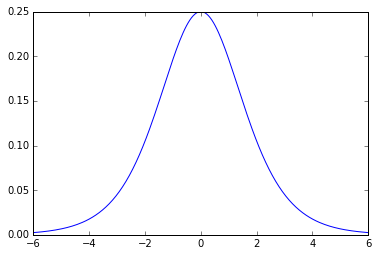

In [49]:
def dactivation(x):
    return np.exp(-x)/((1+np.exp(-x))**2)
plt.plot(segedX,dactivation(segedX))

Most jön a java! Definiáljuk az MLP osztályt négy függvénnyel: inicializálás, súlyok resetelése, forward lépés, backward lépés.

In [50]:
# MLP osztály létrehozása.
class MLP:
    
    # A hálózat inicializálása az argumentumként megadott méretek alapján.
    def __init__(self, *args):
        # random seed megadása
        np.random.seed(123)
        # A hálózat formája (rétegek száma), amely megegyezik a paraméterek számával
        self.shape = args
        n = len(args)
        # Rétegek létrehozása
        self.layers = []
        # Bemeneti réteg létrehozása (+1 egység a BIAS-nak)
        self.layers.append(np.ones(self.shape[0]+1))
        # Rejtett réteg(ek) és a kimeneti réteg létrehozása
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        # Súlymátrix létrehozása
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
        # dw fogja tartalmazni a súlyok utolsó módosításait (a momentum módszer számára)
        self.dw = [0,]*len(self.weights)
        # Súlyok újrainicializálása
        self.reset()
    
    # Súlyok újrainicializálási függvényének definiálása
    def reset(self):
        for i in range(len(self.weights)):
            # véletlen számok [0,1) tartományban 
            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            # átskálázzuk a súlyokat -1..1 tartományba
            self.weights[i][...] = (2*Z-1)*1

    # A bemenő adatok végigküldése a hálózaton, kimeneti rétegig (forward propagation)
    def propagate_forward(self, data):
        # Bemeneti réteg beállítása (tanító adatok)
        self.layers[0][0:-1] = data
        # Az adatok végigküldése a bemeneti rétegtől az utolsó előtti rétegig (az utolsó ugyanis a kimeneti réteg).
        # A szigmoid aktivációs függvény használatával, mátrixszorzások alkalmazásával.
        # Az előadáson a "layers" változót jelöltük "a"-val.
        for i in range(1,len(self.shape)):
            self.layers[i][...] = activation(np.dot(self.layers[i-1],self.weights[i-1]))
        # Visszatérés a hálózat által becsült eredménnyel
        return self.layers[-1]

    # Hibavisszaterjesztés (backpropagation) definiálása. 
    # A a learning rate (tanulási ráta) paraméter befolyásolja, hogy a hálózat súlyait milyen
    # mértékben módosítsuk a gradiens függvényében. Ha ez az érték túl magas, akkor a háló 
    # "oszcillálhat" egy lokális vagy globális minimum körül. Ha túl kicsi értéket választunk,
    # akkor pedig jelentősen több időbe telik mire elérjük a legjobb megoldást vagy leakad egy lokális 
    # minimumban és sose éri el azt.
    # Jelen implementációban a momentum is megvalósításra kerül, mely figyelembe veszi az előző
    # epoch-ban számolt gradienst is. Ez egy fajta regularizációként működik, segíti a tanítást. 
    def propagate_backward(self, target, lrate=0.1, momentum=0.1):
        deltas = []
        # Hiba kiszámítása a kimeneti rétegen
        error = -(target-self.layers[-1]) # y-y_kalap
        # error*dactivation(s(3))
        delta = np.multiply(error,dactivation(np.dot(self.layers[-2],self.weights[-1])))
        deltas.append(delta)
        # Gradiens kiszámítása a rejtett réteg(ek)ben
        for i in range(len(self.shape)-2,0,-1):
            # pl. utolsó rejtett réteg: delta(3)*(W(2).T)*dactivation(s(2)) (lásd előadás)
            delta=np.dot(deltas[0],self.weights[i].T)*dactivation(np.dot(self.layers[i-1],self.weights[i-1]))
            deltas.insert(0,delta)            
        # Súlyok módosítása
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])
            # pl. utolsó rétegben: delta(3)*a(2) (lásd előadás)
            dw = -lrate*np.dot(layer.T,delta) + momentum*self.dw[i]
            # súlyok módosítása
            self.weights[i] += dw 
            '''
            # "hibás", de működő kód
            dw = np.dot(layer.T,delta)
            self.weights[i] -= lrate*dw - momentum*self.dw[i]  
            '''
            # a súlymódosítás eltárolása
            self.dw[i] = dw

        # Visszatérés a hibával
        return (error**2).sum()

In [51]:
def learn(network,samples, valid_split, test_split, epochs=5000, lrate=0.01, momentum=0.9, patience=10):

        # train-validation-test minták különválasztása
        samples_train = samples[0:int(nb_samples*(1-valid_split-test_split))]
        samples_valid = samples[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        samples_test  = samples[int(nb_samples*(1-test_split)):]
    
        # standardizálás
        scaler = preprocessing.StandardScaler().fit(samples_train['input'])
        samples_train['input'] = scaler.transform(samples_train['input'])
        samples_valid['input'] = scaler.transform(samples_valid['input'])
        samples_test['input'] = scaler.transform(samples_test['input'])    
    
        # keverés
        np.random.shuffle(samples_train)
        np.random.shuffle(samples_valid)
        np.random.shuffle(samples_test)
    
        best_valid_err = np.inf
        es_counter = 0 # early stopping counter
        best_model = network
    
        # Tanítási fázis, epoch-szor megyünk át 1-1 véltelenszerűen kiválasztott mintán.
        for i in range(epochs):
            # Jelen megoldás azt a módszert használja, hogy a megadott 
            # tanító adatokon végigmegyünk és minden elemet először végigküldünk
            # a hálózaton, majd terjeszti vissza a kapott eltérést az
            # elvárt eredménytől. Ezt hívjuk SGD-ek (stochastic gradient descent).
            train_err = 0
            for k in range(samples_train.size):
                network.propagate_forward( samples_train['input'][k] )
                train_err += network.propagate_backward( samples_train['output'][k], lrate, momentum )
            train_err /= samples_train.size

            # validációs fázis
            valid_err = 0
            o_valid = np.zeros(samples_valid.size)
            for k in range(samples_valid.size):
                o_valid[k] = network.propagate_forward(samples_valid['input'][k])
                valid_err += (o_valid[k]-samples_valid['output'][k])**2
            valid_err /= samples_valid.size

            # Legjobb modell elmentése és early stopping
            if valid_err < best_valid_err:
                best_valid_err = np.round(valid_err,3)
                es_counter = 0
                best_model = copy.copy(network)
                print("New best model found")
            else:
                es_counter += 1

            print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))

            if es_counter > patience:
                print("Early stoping, loading back best model")
                network=best_model
                break
            
        # Tesztelési fázis
        test_err = 0
        o_test = np.zeros(samples_test.size)
        for k in range(samples_test.size):
            o_test[k] = network.propagate_forward(samples_test['input'][k])
            test_err += (o_test[k]-samples_test['output'][k])**2
            print(k, samples_test['input'][k], '%.2f' % o_test[k], \
                  ' (elvart eredmeny: %.2f)' % samples_test['output'][k])
        test_err /= samples_test.size

        fig1=plt.figure()
        plt.scatter(samples_test['input'][:,0], samples_test['input'][:,1], c=np.round(o_test[:]), cmap=plt.cm.cool)

In [52]:
# Mesterséges neurális hálózat létrehozása, 2 bemenettel, 10 rejtett neuronnal és 1 kimenettel
network = MLP(2,10,1)

In [53]:
# Tanító minta táblázatának létrehozása
samples = np.zeros(4, dtype=[('input',  float, 2), ('output', float, 1)])

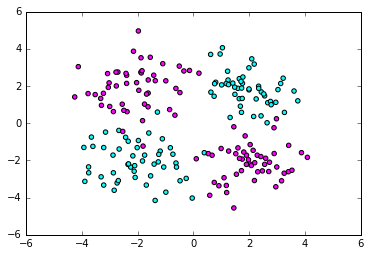

In [54]:
# Tanító, validációs és teszt adatok megadása a rendszernek (zajjal terhelt XOR adatok)
nb_samples=200
samples=np.zeros(nb_samples, dtype=[('input', float, 2), ('output', float, 1)])
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    samples[i] = (-2+noise[0],-2+noise[1]), 0
    samples[i+1] = (2+noise[2],-2+noise[3]), 1
    samples[i+2] = (-2+noise[4],2+noise[5]), 1
    samples[i+3] = (2+noise[6],2+noise[7]), 0

# ...és az adatok kirajzolása
fig1=plt.figure()
plt.scatter(samples['input'][:,0],samples['input'][:,1],c=samples['output'][:], cmap=plt.cm.cool)

New best model found
0 epoch, train_err: 0.3488, valid_err: 0.2776
New best model found
1 epoch, train_err: 0.2553, valid_err: 0.2553
New best model found
2 epoch, train_err: 0.2528, valid_err: 0.2543
New best model found
3 epoch, train_err: 0.2521, valid_err: 0.2529
New best model found
4 epoch, train_err: 0.2512, valid_err: 0.2517
New best model found
5 epoch, train_err: 0.2502, valid_err: 0.2505
New best model found
6 epoch, train_err: 0.2492, valid_err: 0.2493
New best model found
7 epoch, train_err: 0.2481, valid_err: 0.2481
New best model found
8 epoch, train_err: 0.2469, valid_err: 0.2468
New best model found
9 epoch, train_err: 0.2456, valid_err: 0.2455
New best model found
10 epoch, train_err: 0.2441, valid_err: 0.2440
New best model found
11 epoch, train_err: 0.2425, valid_err: 0.2423
New best model found
12 epoch, train_err: 0.2406, valid_err: 0.2405
New best model found
13 epoch, train_err: 0.2384, valid_err: 0.2384
New best model found
14 epoch, train_err: 0.2360, valid_er

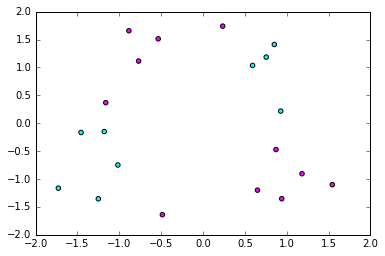

In [55]:
# Tanítás/Tesztelés indítása
network.reset()
learn(network, samples, 0.2, 0.1)